In [1]:
cd(@__DIR__)
include(raw"utils\utils.jl")

Undrift!

Making a calendar of 100 years

In [2]:
try 
    using Dates
catch ; 
    import Pkg
    Pkg.add("Dates")
    using Dates
end
k=100
DatesRange=collect(Date(1900):Day(1):Date(1900+k))
N=length(DatesRange)

36525

# AR model on the whole series

## AR(2)

In [3]:
condition(r) = (imag(r) == 0) && (abs(r) > 1)
isstationnary(R::Vector)=all(condition.(RootAR(R)))

isstationnary (generic function with 1 method)

In [4]:
x0=[7.,-3]
Φ,σ=[0.1,0.5],6
isstationnary([0.1,0.5])

true

In [5]:
include("utils/Simulation.jl")
x=[x0 ; simulation(x0,Φ,σ,N-length(x0))]

36525-element Vector{Float64}:
   7.0
  -3.0
   9.927105801580879
   8.15630929956777
   8.169210723121179
  -1.3423155664453246
   6.273914279915387
   5.501165759207082
  -6.6104587346146495
  -6.904284847711858
   ⋮
  -5.056852669989009
 -13.16915757405659
  -3.639320175489059
  -9.009884718852879
  -6.435373129347493
   1.5105425341104617
   0.6170608537394138
  -0.34198054008675627
  -2.894005505557332

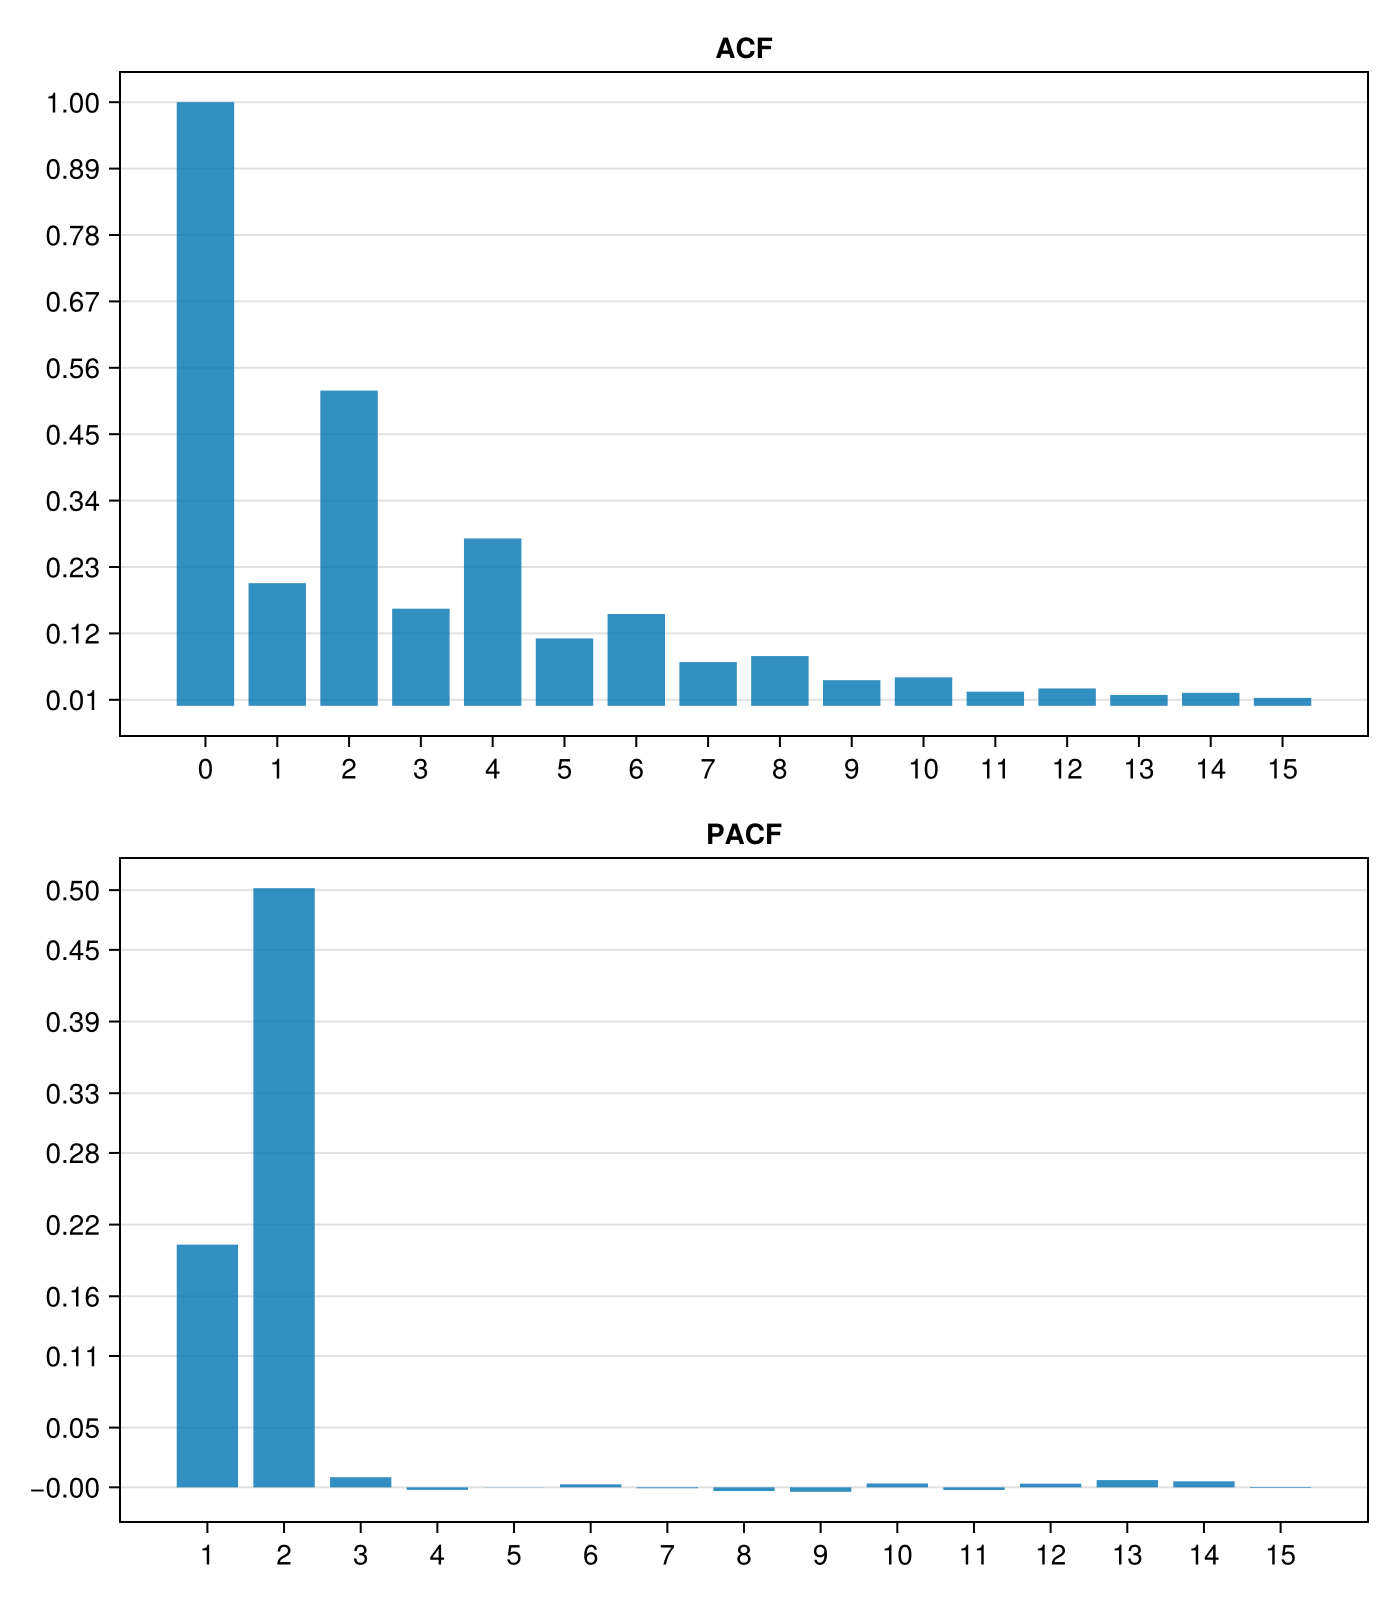

In [6]:
include("utils/ACF_PACF.jl")
ACF_PACF(x)

In [7]:
include("utils/Estimation.jl")
Parameters_est=LL_AR_Estimation(x,2)
Φ1_hat, Φ2_hat, σ_hat=Parameters_est[1][1], Parameters_est[1][2], Parameters_est[2]
table = DataFrame("Parameters"=>"Φ₁", "Error"=>abs(Φ1_hat-Φ[1]), "Relative error"=>abs(Φ1_hat-Φ[1])/abs(Φ[1]))
push!(table,("Φ₂",abs(Φ2_hat-Φ[2]),abs(Φ2_hat-Φ[2])/abs(Φ[2])))
push!(table,("σ",abs(σ_hat-σ),abs(σ_hat-σ)/abs(σ)))

Row,Parameters,Error,Relative error
,String,Float64,Float64
1,Φ₁,0.00131915,0.0131915
2,Φ₂,0.00166328,0.00332657
3,σ,0.0455826,0.0075971


# AR model on each month

Parameters for each month

To find convenient parameters, below I have made an empirical map of where the parameters make the AR(2) series stationnary (in blue) and where they don't (in red)

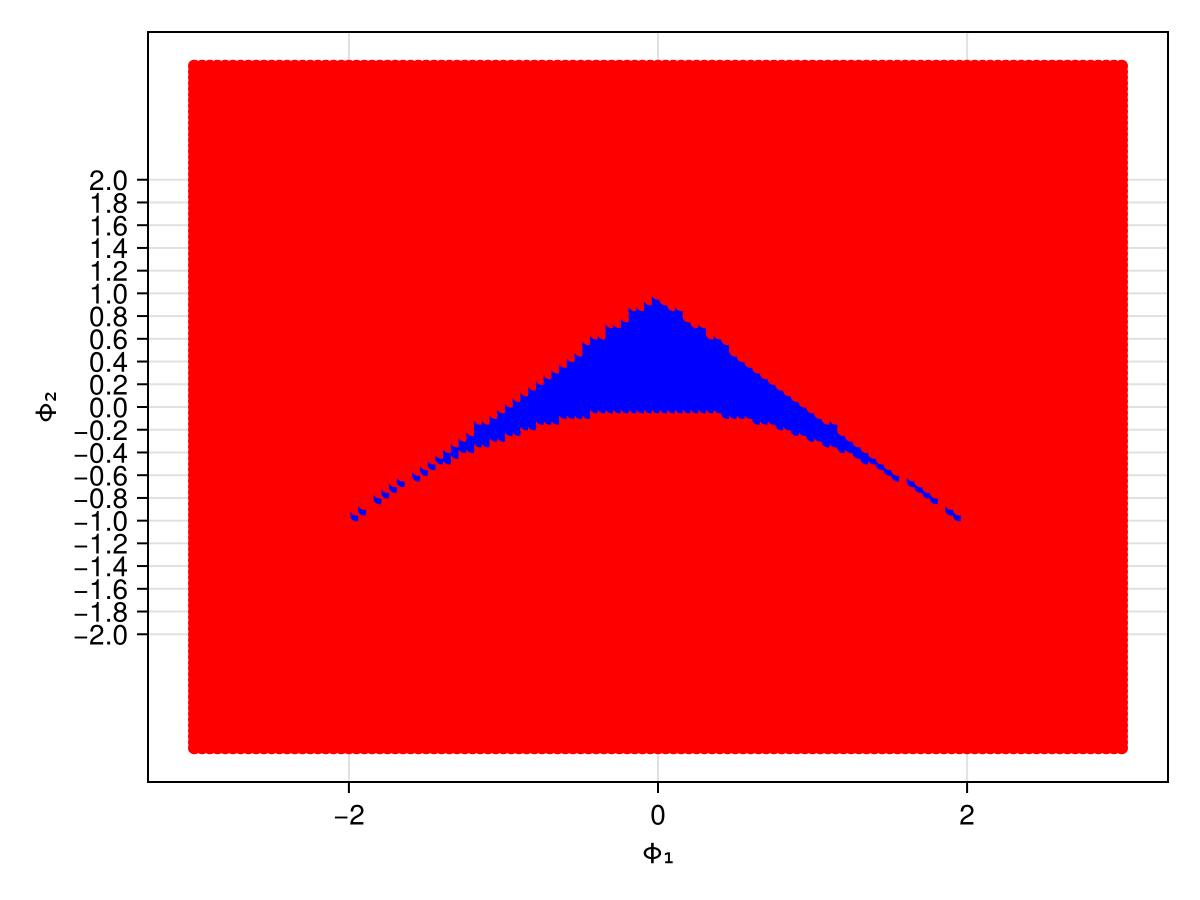

In [8]:
fig=Figure()
ax=Axis(fig[1,1])
ax.yticks=-2:0.2:2
Φ₁ls=-3:.05:3
Φ₂ls=-3:.05:3
condition(r) = (imag(r) == 0) && (abs(r) > 1)
for Φ₁ in Φ₁ls
    for Φ₂ in Φ₂ls
        color = all(condition.(RootAR([Φ₁,Φ₂]))) ? "blue" : "red" 
        scatter!(ax, Φ₁,Φ₂, color=color)
        ax.ylabel="Φ₂"
        ax.xlabel="Φ₁"
    end
end
fig

In [9]:
Φ_month=[[5,2],[-7,1],[1,8],[6,2],[-2,7],[0.5,9],[-3,2],[5,4],[3,1],[-4,3],[3,1],[5,2]] / 10
display(isstationnary.(Φ_month))
Φ1_month, Φ2_month = invert(Φ_month)
σ_month=[1.5,2,4.5,7,8,3,4.5,1,7,2.5,3,6]

12-element BitVector:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

12-element Vector{Float64}:
 1.5
 2.0
 4.5
 7.0
 8.0
 3.0
 4.5
 1.0
 7.0
 2.5
 3.0
 6.0

Generation of the series associated

In [10]:
n_month=200
x=SimulateMonth([7.,4.],Date(2000,11,2),Φ_month,σ_month,n_month)
Date_vec=collect(Date(2000,11,1):(Date(2000,11,1) + Month(n_month) - Day(1)))
Monthly_temp=MonthlySeparateX(x,Date_vec)

12-element Vector{Vector{AbstractVector}}:
 [[4.579528755249298, 4.809849047369788, 4.458744332062092, 0.02357534895635105, 1.0049649476653166, 0.7547883127776389, 0.27405947354426907, -0.0005863513266300413, -3.0098275019889367, -0.9327540627888822  …  -1.7770925279600251, -2.2904169870319144, -2.6697720613744744, -0.3515390314970468, -1.7114080066878388, -0.8379582502832793, -2.987273353434853, 0.16469571982734377, 0.6038757309444336, 1.0383089775629288], [1.3376303119248178, 3.1209513171343173, 1.914228266220739, 3.1860645431306867, 2.598625515539087, 0.22857235005022103, -0.03988667647993627, 2.1775396069329958, 1.12582494568543, 2.3878333964805063  …  0.5466282702305609, -1.2381143716426048, 0.2941973172207213, -0.2185733271515243, 1.542153978005221, -1.2226788946957643, 0.8240584959511381, -2.304189303285294, -0.9349195255479117, -4.240632983769587], [-4.031182964765553, -6.228839463638106, -4.687538487919064, -3.2678136194913288, -0.4341035580225916, -1.9305728412654029, -3.2405

## Autocorrelations

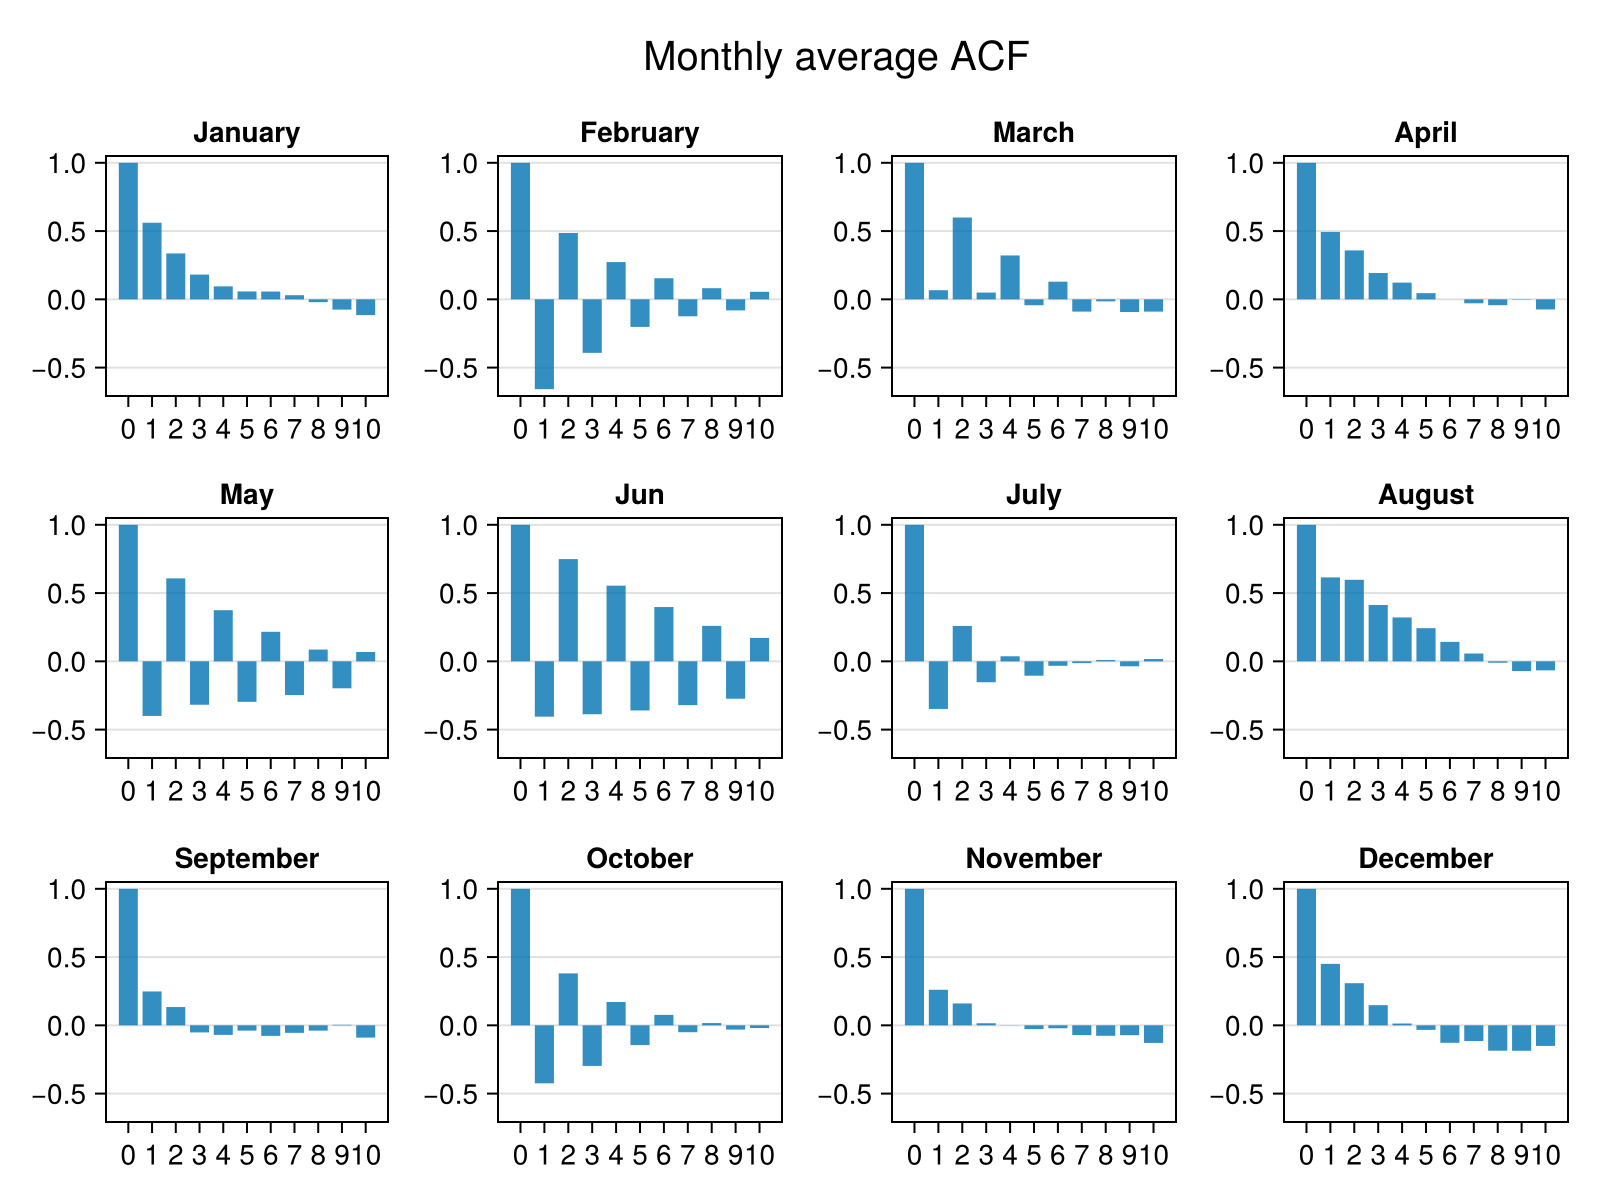

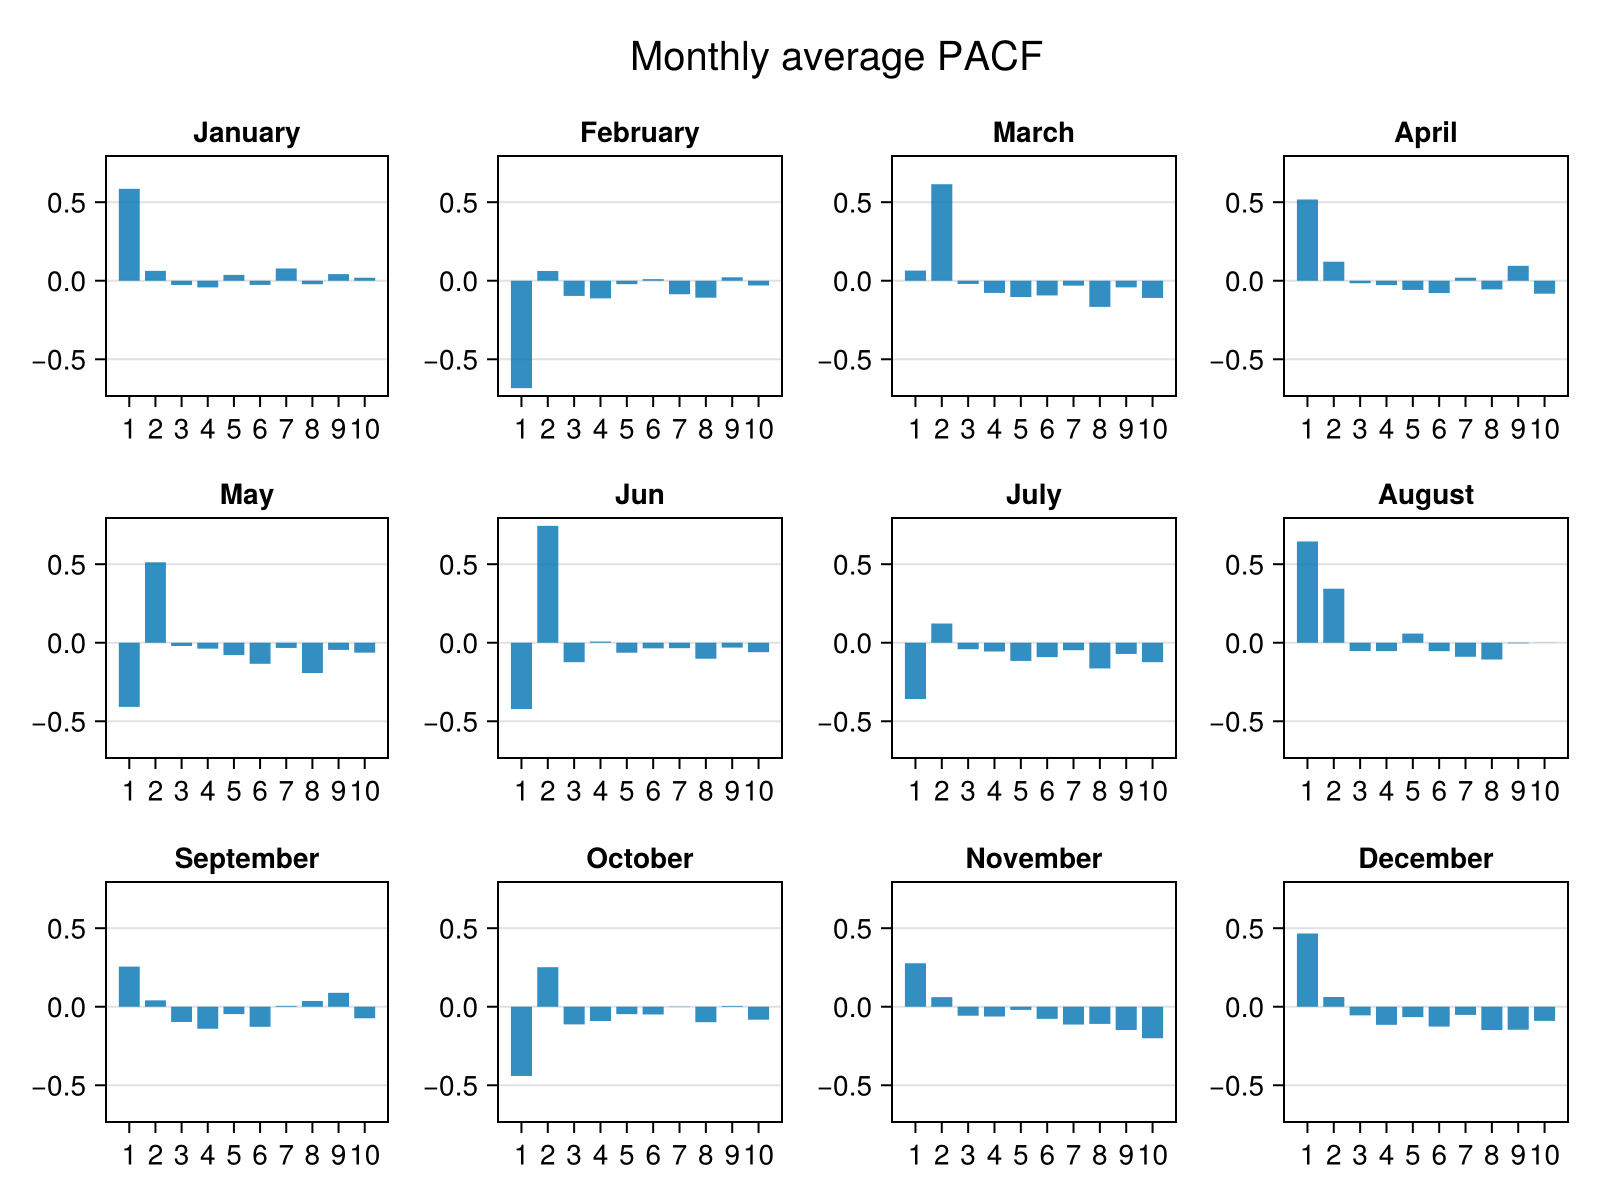

CairoMakie.Screen{IMAGE}


In [11]:
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

## Estimating models

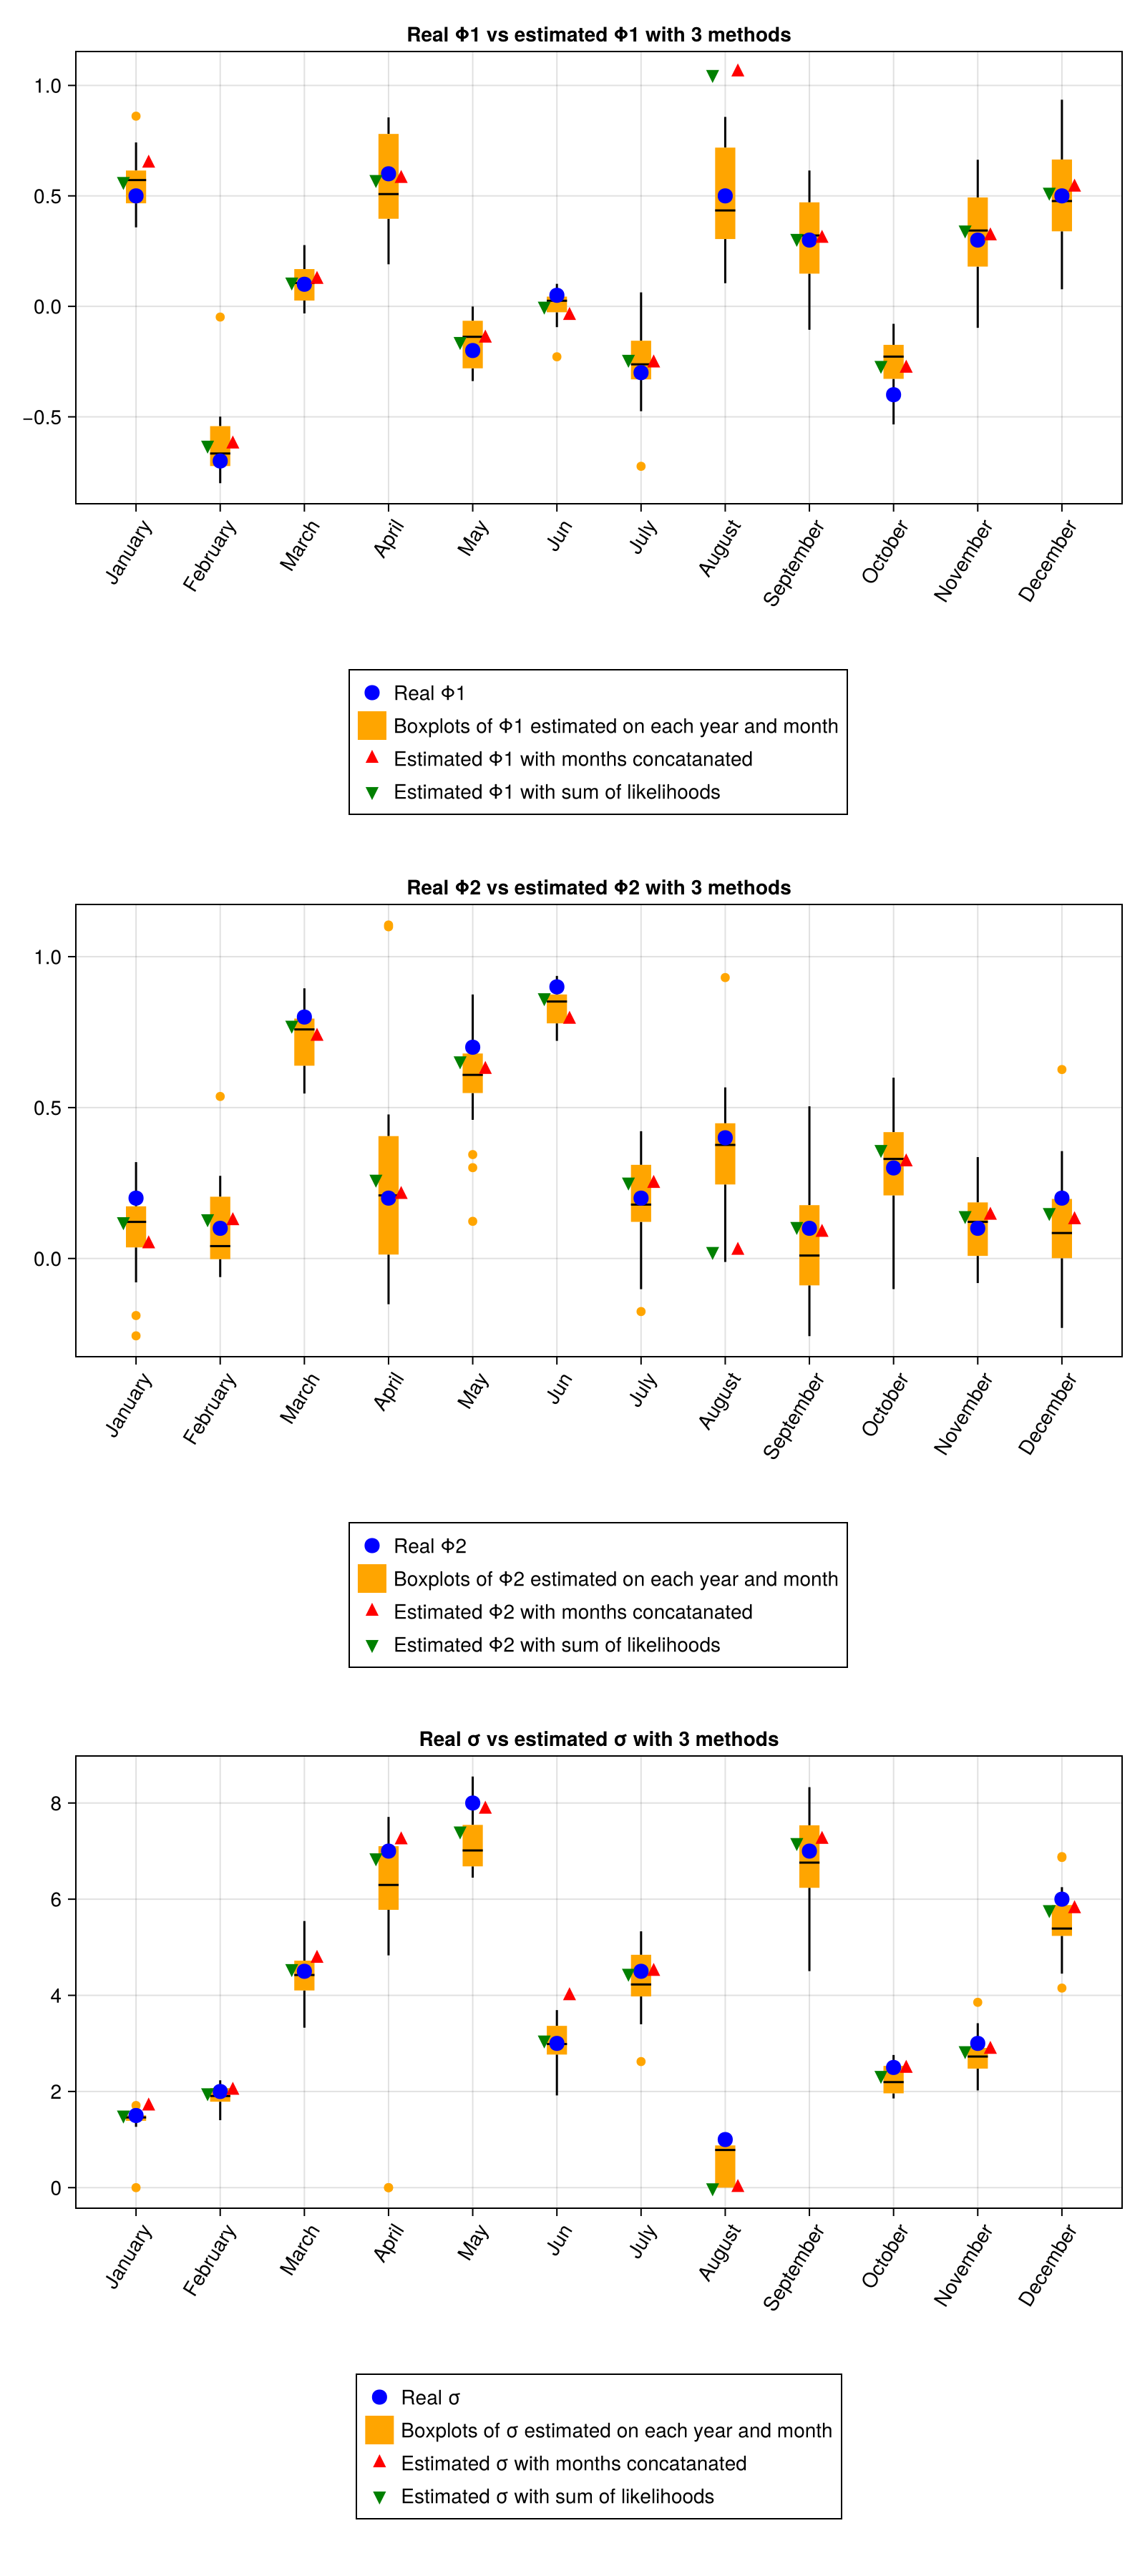

Row,Parameter,Month concatanation,Sum LL,mean of monthly parameters,median of monthly parameters
,String,Float64,Float64,Float64,Float64
1,Φ1,37.4743,28.4595,17.5514,17.932
2,Φ2,29.4957,27.5573,19.8616,26.8638
3,σ,14.1581,11.1157,10.1589,7.86869


6

In [12]:
include(raw"utils\Estimation.jl")
Parameters,autofig,ErrorTable=AllEstimation(x,2,Date_vec=Date_vec,TrueParamVec=[Φ1_month,Φ2_month,σ_month])
display(autofig)
display(ErrorTable)

In [13]:
Φ_vec, σ_vec = AutoTakeParameters((Parameters,ErrorTable))
n_years=100
sim=SimulateYears([7.,4.],Date(2001,1,2),Φ_vec, σ_vec,n_years)
sample_=invert(sim)

365-element Vector{Vector{Float64}}:
 [7.0, 5.1436631369514, 1.9582161698212261, -1.324150168879365, -7.738389065236387, -5.269429233706202, 1.4451845497203826, 1.505302047348301, -3.7806563603105614, -8.00686925979999  …  -2.4667534756416822, 0.24006090458088591, -0.10605487638378275, 2.9371331299841676, 6.1875842573296405, 2.43181059233195, 4.00448538522974, 0.3525975922708544, -1.0657195722395407, -5.633779898056236]
 [4.0, 4.054413479204092, -0.23465070635763507, -0.3312913916718281, -3.7692114775916954, -0.9139966012309193, 1.0354808976633065, 1.4705079344469487, -2.7801964233621534, -4.982032045830036  …  -4.034878401691055, -1.08724888746056, -1.4389842943912203, 3.452284281962782, 5.061226429296423, 0.22970222639239513, 3.8399392250849167, 0.43606317493406527, 0.3303226630142002, -2.0214585408132]
 [1.801608079065677, 2.228734010229984, 0.08182895633009415, -1.8092843444067706, -3.3734869617157113, 0.29526478150014945, -1.2022085466701595, 1.0524309830992213, -1.192641640871447

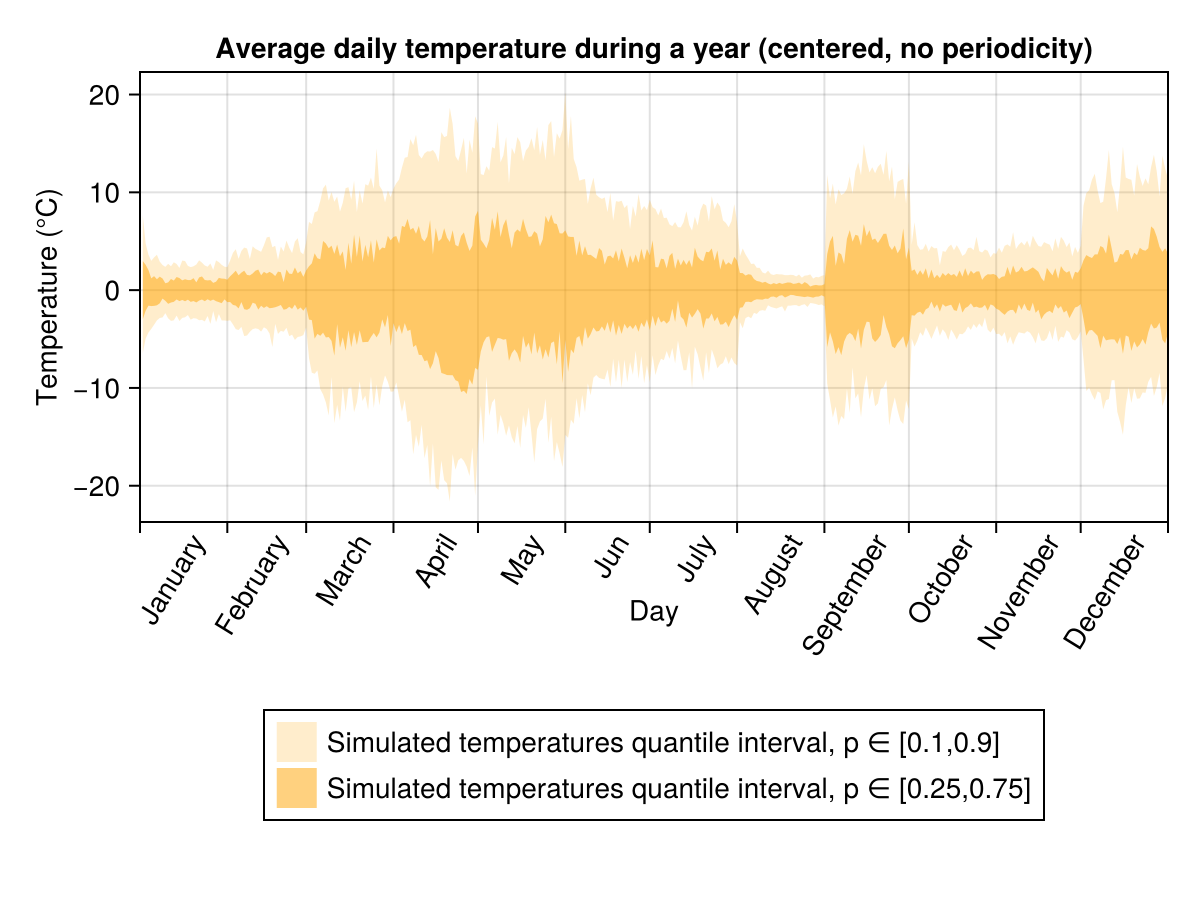

In [15]:
include("utils/Plotting.jl")
PlotYearCurves([],
["Simulated temperatures quantile interval, p ∈ [0.1,0.9]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered, no periodicity)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
)